In [1]:
import acquire
import prepare
import explore
import model

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Project Overview

We will conduct an in depth analysis of Zillow property data from 2017. We will use exploratory analysis techniques to identify the key drivers of the assessed tax value for those properties, then use machine learning algorithms to create a model capable of predicting tax values based on features of the property. 

# Project Description

Property values have skyrocketed over the last two years. With such rapid changes in home values, predicting those values has become even more challenging than before. Since Zillow's estimate of home value is one of the primary drivers of its website traffic, having a reliable estimate is paramount. Any improvement we can make on the previous model will help us out-estimate our competitors and keep us at the top as the most trusted name in real estate technology. 

This project will analyze property attributes in relation to their 2017 assessed tax value, develop a model for predicting that value based on those attributes, and leave with recommendations for how to improve future predictions. 

# Project Goals

By improving upon the previous model, Zillow can enhance it's reputation for reliable property value estimates and better position itself in the real estate technology marketplace. 


# Acquisition

In this stage, we use a SQL query to access the Codeup MySQL database and join together all the relevant data using the following tables:

- properties_2017
- propertylandusetype
- predictions_2017

The data obtained includes all properties in the dataset which had a transaction in 2017.

In [2]:
df = acquire.zillow_2017_data()

Reading from local CSV...


# Preparation

In this stage, we clean and prepare the data for further exploration and modeling and encapsulate the relevant code in the prepare modele. 

The `prep_zillow_1` function accomplishes the following:

- checks for null values and removes all rows with null values if the number of null values is less than 5% the number of observations in the dataset. 
    - less than 5% of values is judged to not have a significant effect on a large dataset. Greater than 5% of values might require additional consideration. 
    - in this case we removed about 0.2% of the total observations due to null values
- renames columns for readability
- changes data types where appropriate (such as numerical codes into string values)
- adds a feature 'age', which represents years since the home was constructed

In [3]:
df = prepare.prep_zillow_1(df)

**Split the data** into train, test, and validate samples

In [4]:
train, test, validate = prepare.train_test_validate_split(df)

train	 n = 29298
test	 n = 10464
validate n = 12557


**Removing Outliers**

During initial exploration, it was discovered that extreme outliers exist in the categories of tax_value, bedrooms, bathrooms, sqft, and age. 

We judge that out model will generalize more effectively if it is focused on the typical (i.e. median) homes. Further, we expect that markets for luxury and historical homes (likely represented by these outliers) are considerably different than the general home market, and that an altogether separate model would be more useful for predicting the values of such homes. 

We will therefore drop outliers from this dataset. 

The `remove` outliers function calculates a range defining outliers based on the training sample, then removes values outside this range in all samples.

In [5]:
# remove outliers based on a range calculated from the training sample
train, validate, test = prepare.remove_outliers(train, validate, test, 1.5, ['bedrooms', 'bathrooms',                                                                        'sqft', 'age', 'tax_value'])

# Exploration

**Univariate Exploration:** Examining the distributions of our target and each of our features

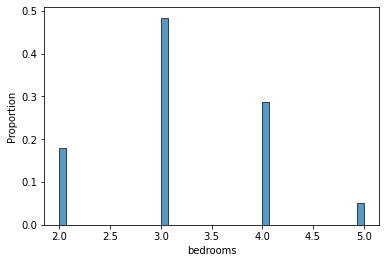

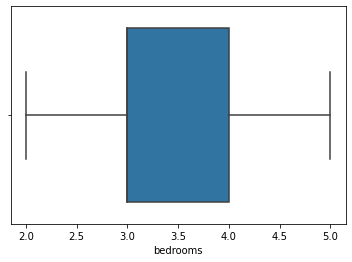

           bedrooms
count  25374.000000
mean       3.209151
std        0.789395
min        2.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000


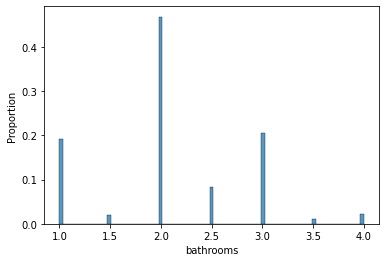

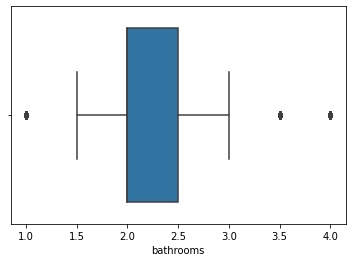

          bathrooms
count  25374.000000
mean       2.107512
std        0.723872
min        1.000000
25%        2.000000
50%        2.000000
75%        2.500000
max        4.000000


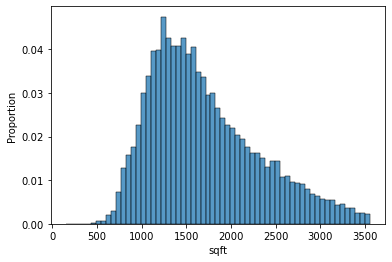

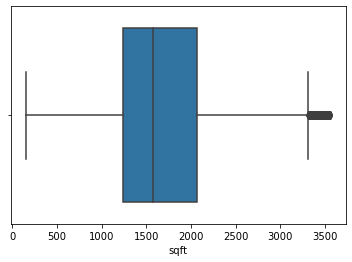

               sqft
count  25374.000000
mean    1703.199574
std      610.286586
min      152.000000
25%     1241.000000
50%     1574.000000
75%     2069.000000
max     3557.000000


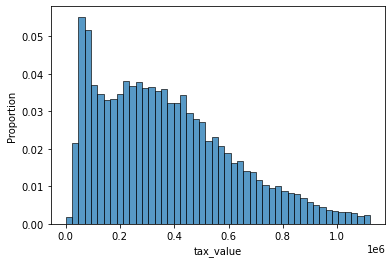

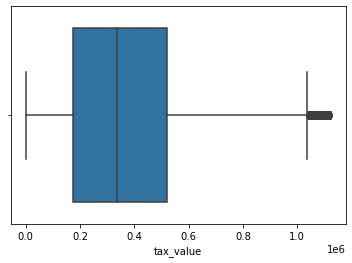

          tax_value
count  2.537400e+04
mean   3.720307e+05
std    2.429898e+05
min    1.000000e+03
25%    1.747200e+05
50%    3.360820e+05
75%    5.200000e+05
max    1.121292e+06


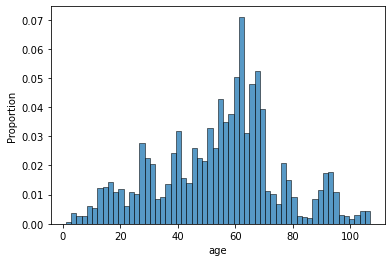

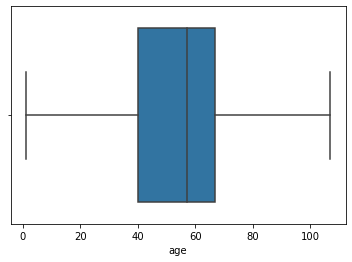

                age
count  25374.000000
mean      54.458304
std       21.214934
min        1.000000
25%       40.000000
50%       57.000000
75%       67.000000
max      107.000000


In [6]:
# define quantitative columns
quantitative_columns = [col for col in train.columns if train[col].dtype != 'object']

# for each of those columns:
for col in quantitative_columns:

        # display a histogram of that column's distribution
        sns.histplot(train[col], stat='proportion')
        plt.show()

        # display a boxplot of that column's distribution
        sns.boxplot(train[col])
        plt.show()

        # display the summary statistics of the distribution
        print(pd.DataFrame(train[col].describe()))

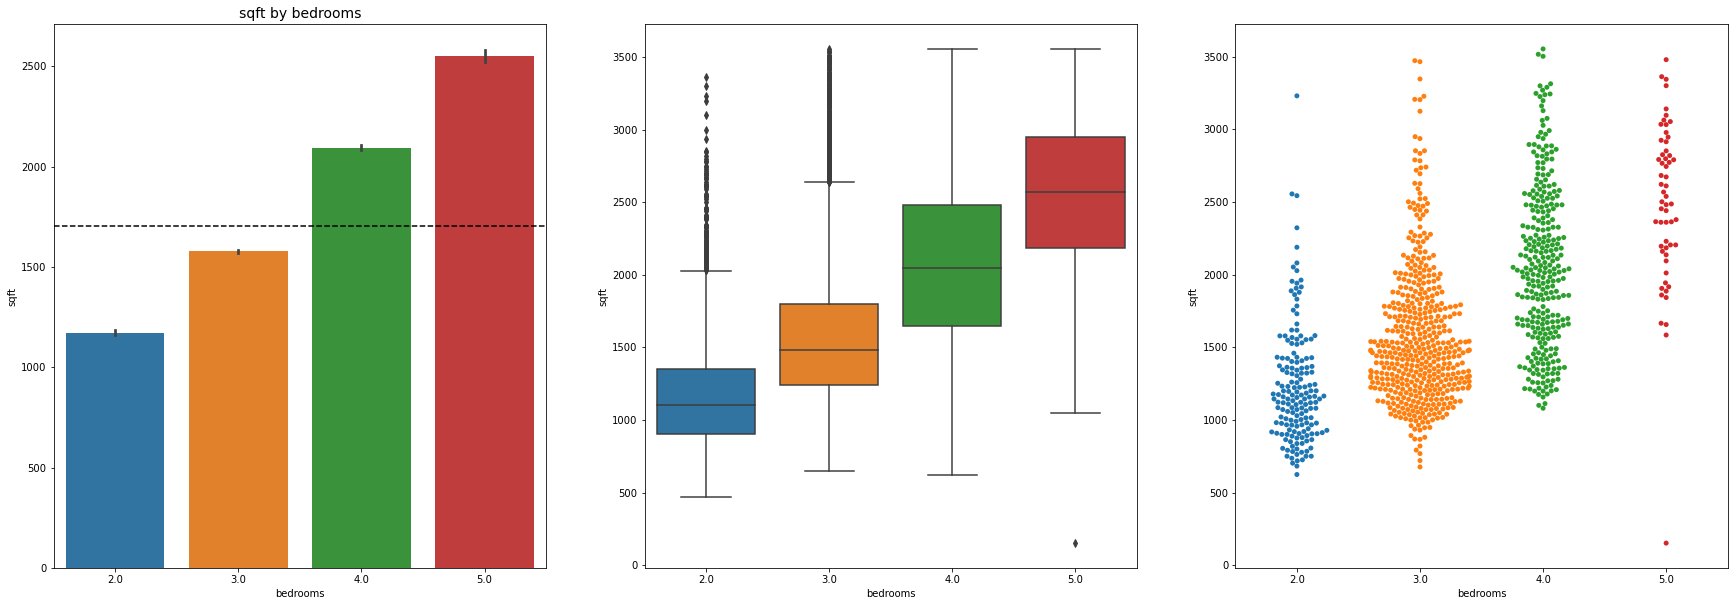

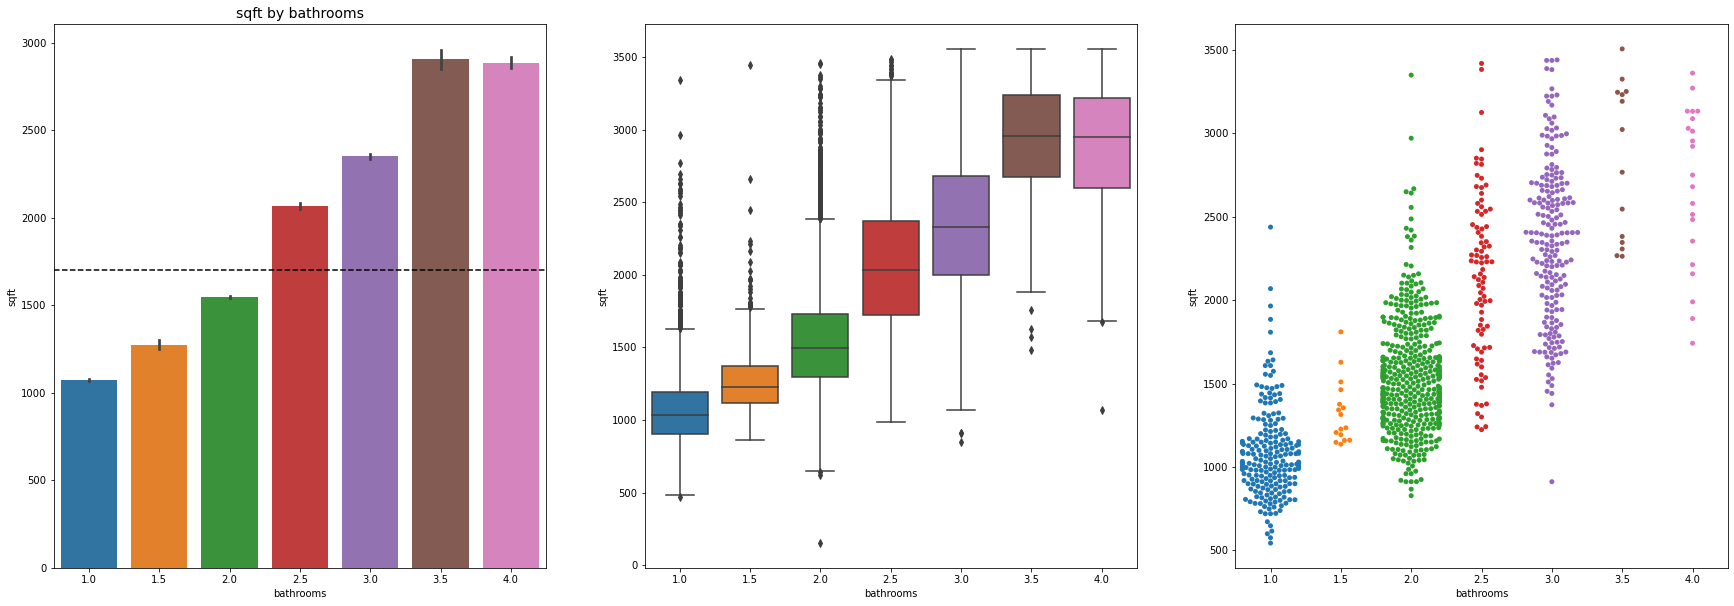

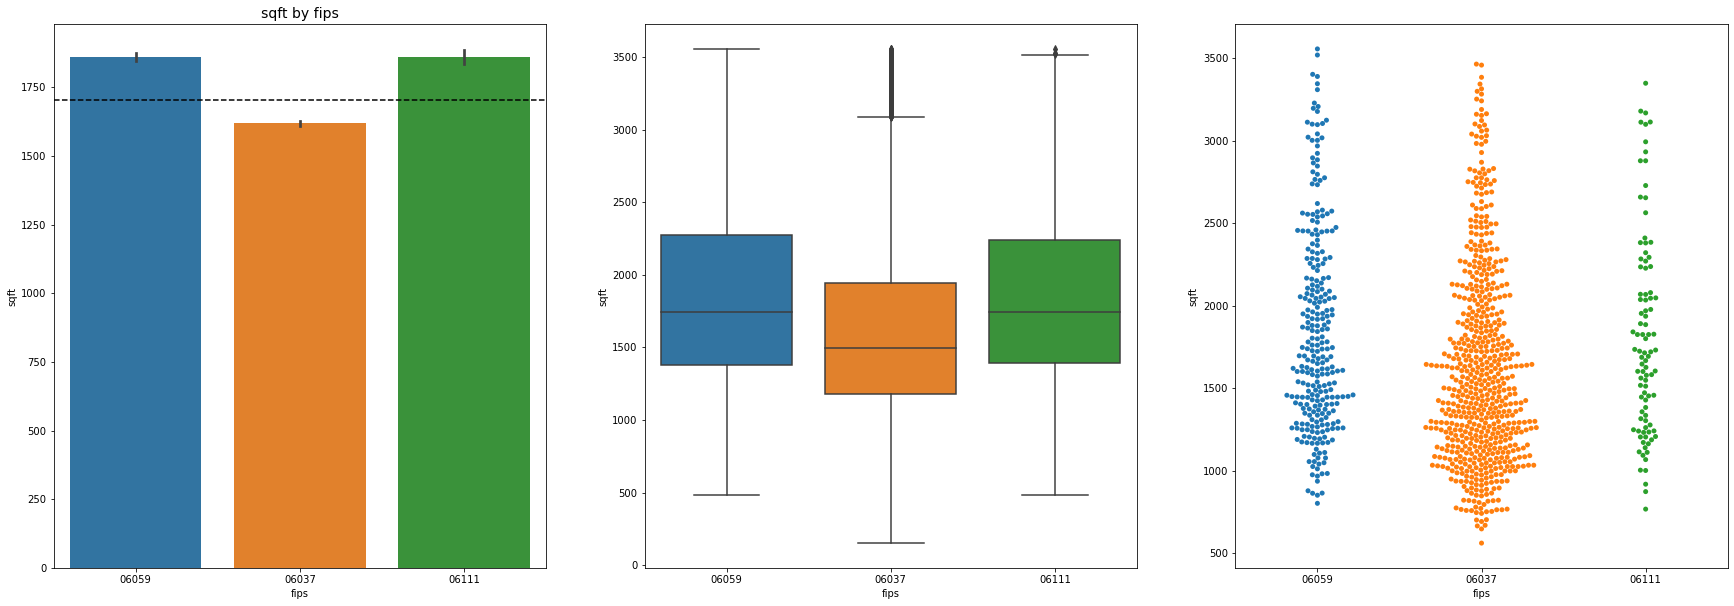

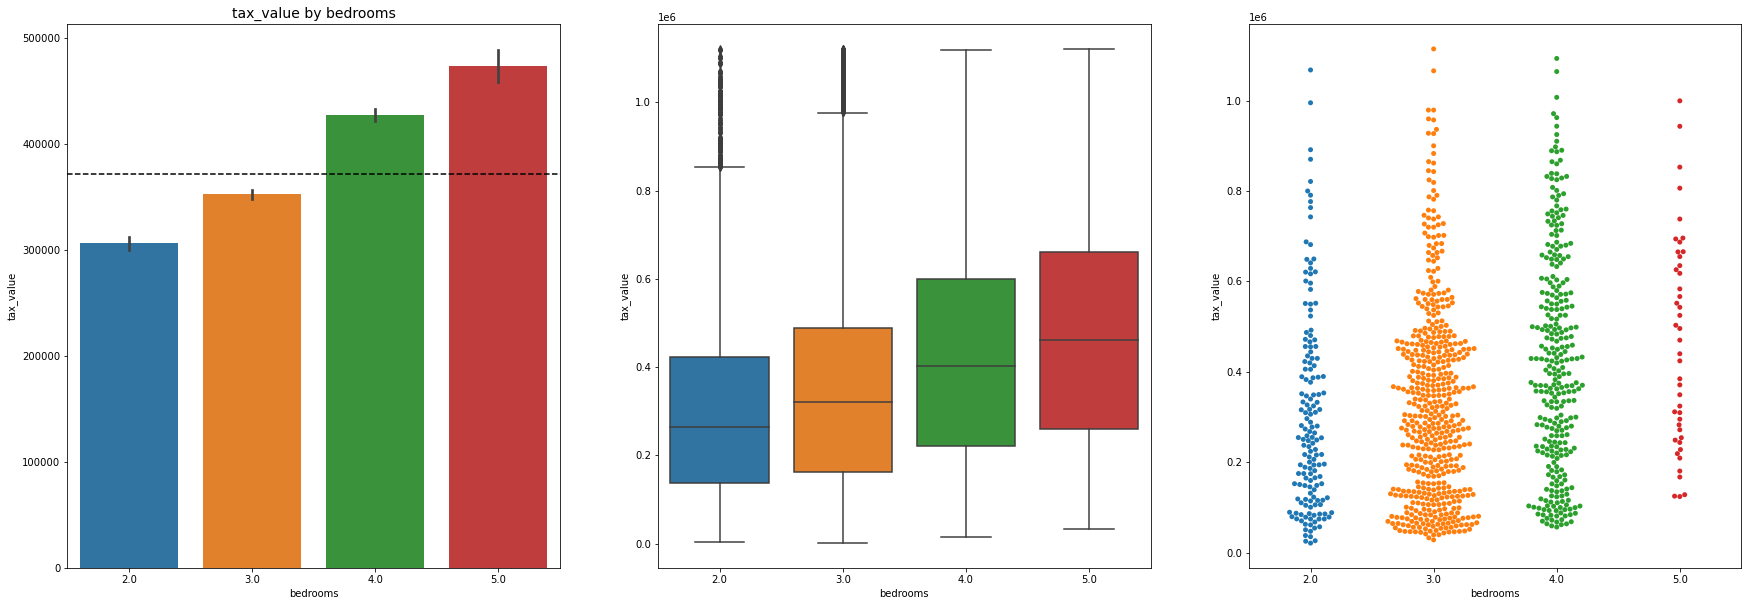

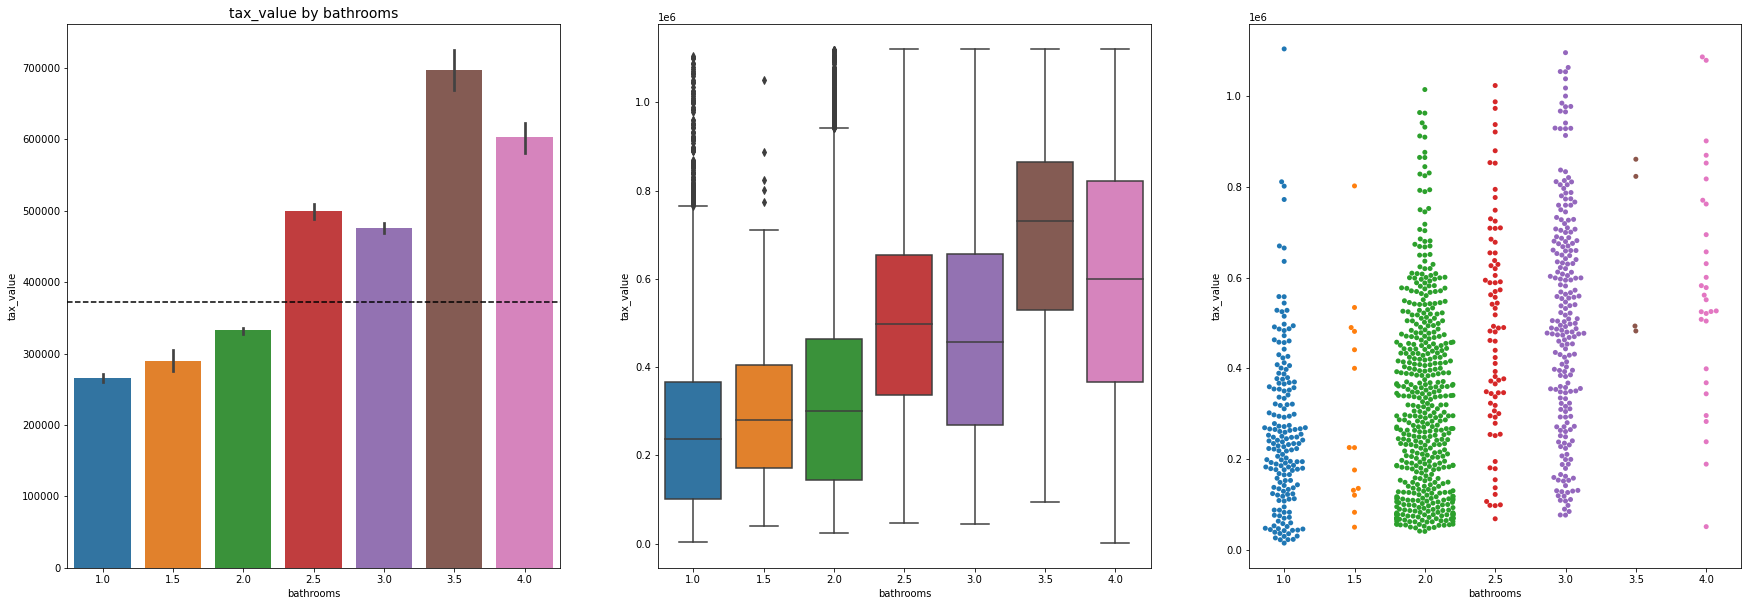

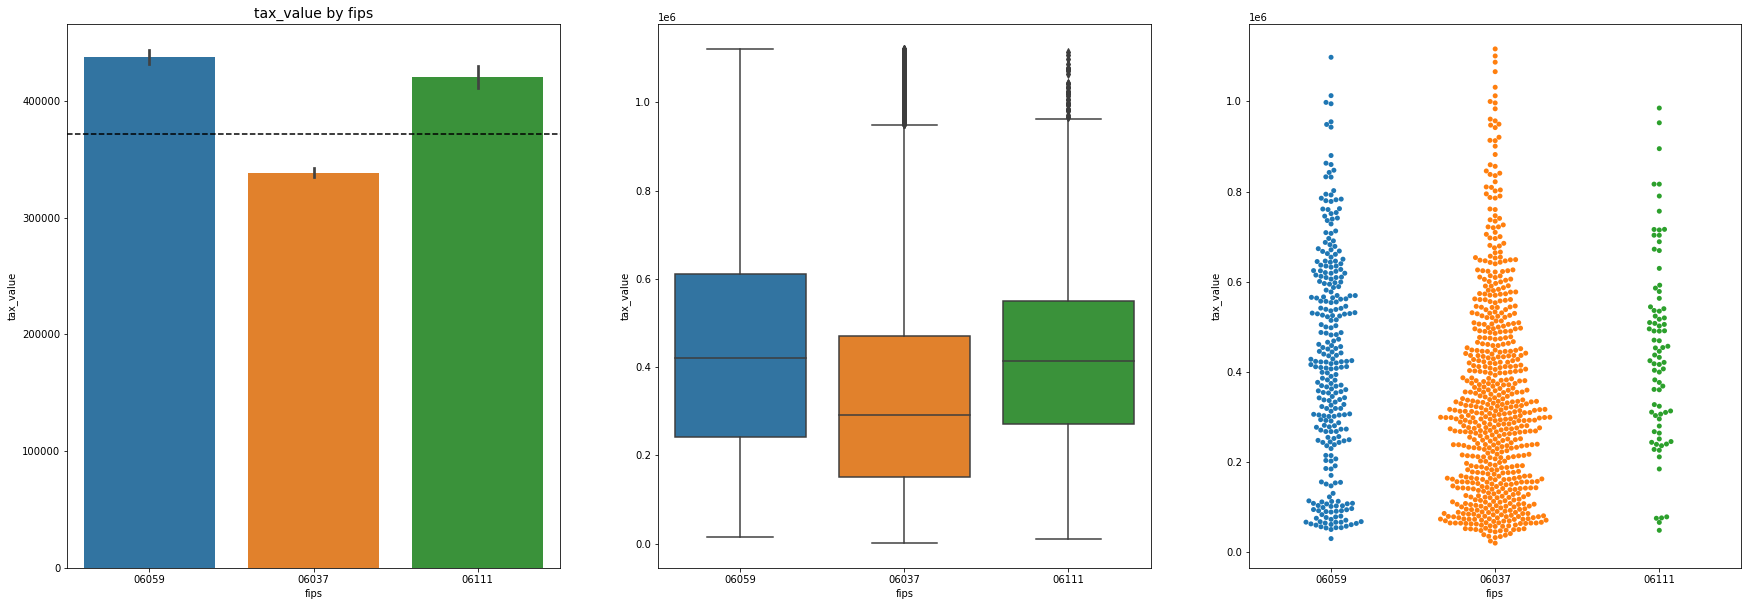

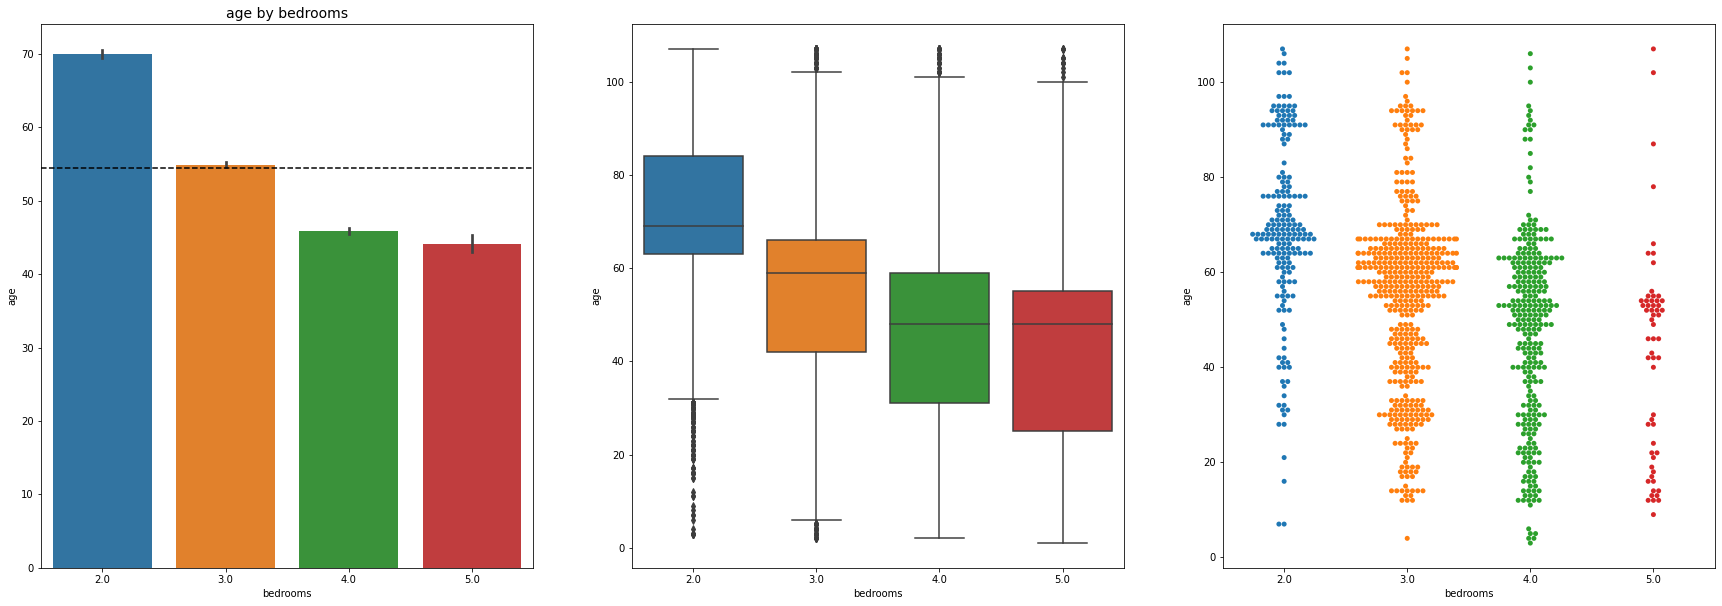

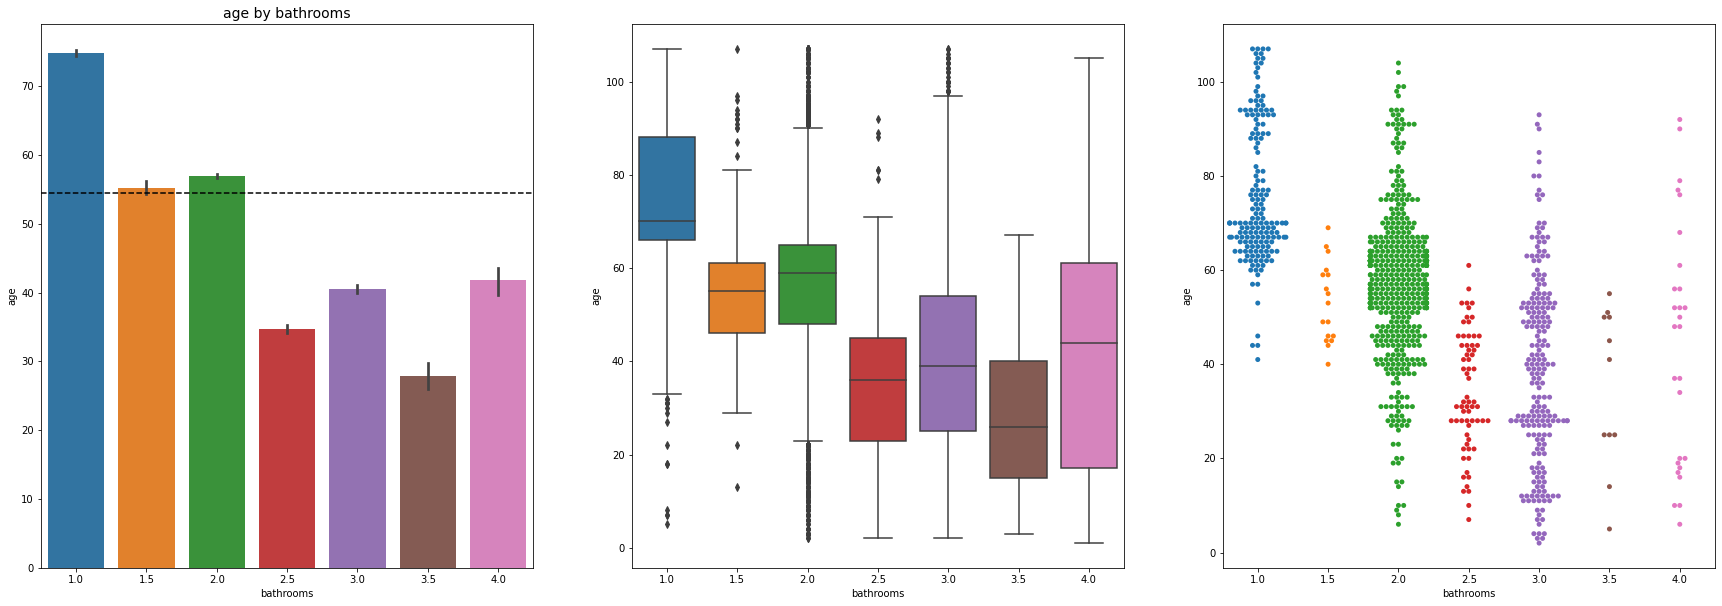

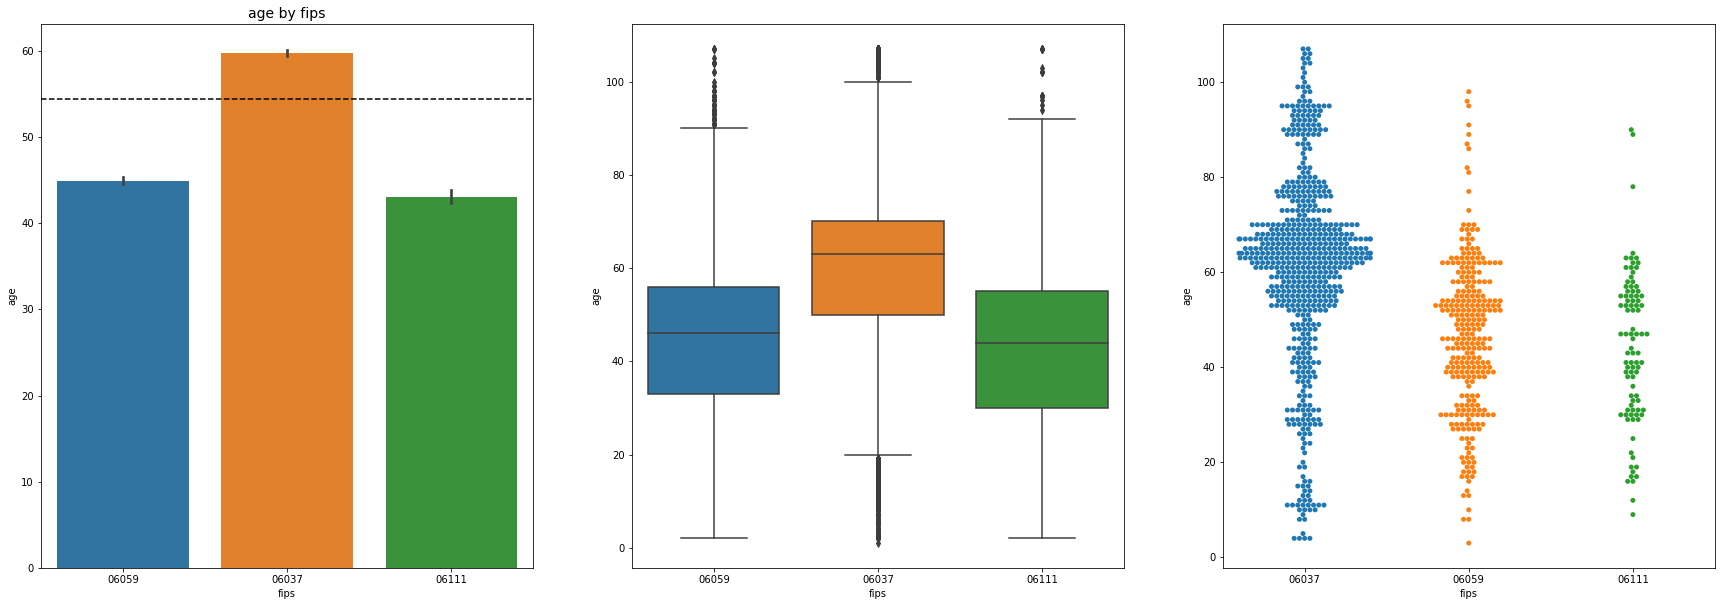

In [7]:
categ_vars = [col for col in train.columns if (train[col].dtype == 'object') or (len(train[col].unique()) < 10)]
cont_vars = [col for col in train.columns if (col not in categ_vars)]

def plot_categorical_and_continuous_vars(train, categ_vars, cont_vars):    
    for cont_var in cont_vars:
        for categ_var in categ_vars:

            plt.figure(figsize=(30,10))
            
            # barplot of average values
            plt.subplot(131)
            sns.barplot(data=train,
                        x=categ_var,
                        y=cont_var)
            plt.axhline(train[cont_var].mean(), 
                        ls='--', 
                        color='black')
            plt.title(f'{cont_var} by {categ_var}', fontsize=14)
            
            # box plot of distributions
            plt.subplot(132)
            sns.boxplot(data=train,
                          x=categ_var,
                          y=cont_var)
            
            # swarmplot of distributions
            
            # for larger datasets, use a sample of n=1000
            if len(train) > 1000:
                train_sample = train.sample(1000)

                plt.subplot(133)
                sns.swarmplot(x=categ_var,
                              y=cont_var,
                              data=train_sample)
            
            # for smaller datasets, plot all data
            else:
                plt.subplot(133)
                sns.swarmplot(x=categ_var,
                              y=cont_var,
                              data=train)
            plt.show()

plot_categorical_and_continuous_vars(train, categ_vars, cont_vars)

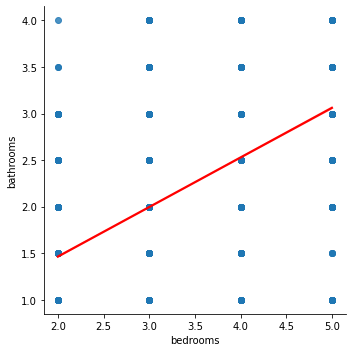

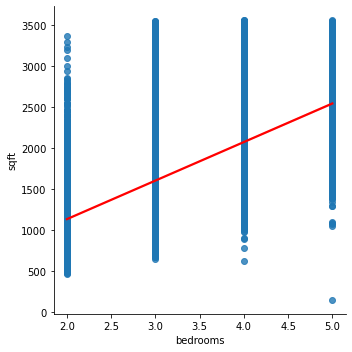

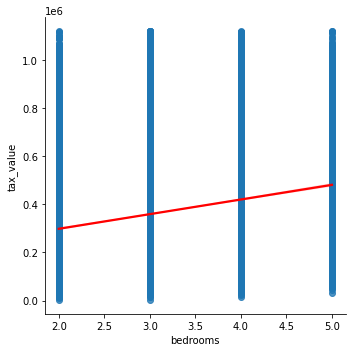

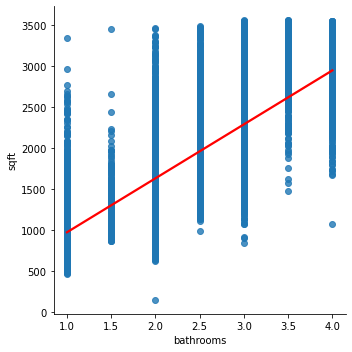

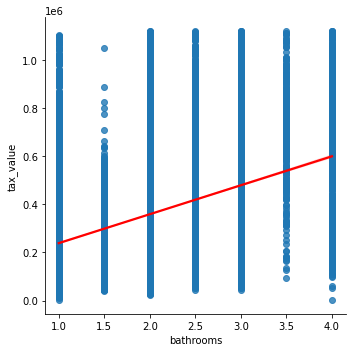

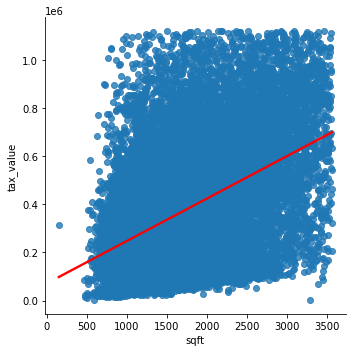

In [8]:
quant_features = ['bedrooms', 'bathrooms', 'sqft', 'tax_value']

import itertools

def plot_variable_pairs(train, features):
    feature_combos = list(itertools.combinations(features, 2))
    for combo in feature_combos:
        sns.lmplot(x=combo[0], y=combo[1], data=train, line_kws={'color': 'red'})
        plt.show()
        
plot_variable_pairs(train, quant_features)
        

### Further Exploration: which features have the highest correlations with tax_value?

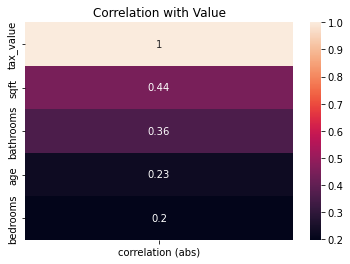

In [9]:
corr = pd.DataFrame(train.corr().abs().tax_value).sort_values(by='tax_value', ascending=False)
corr.columns = ['correlation (abs)']
sns.heatmap(corr, annot=True)
plt.title('Correlation with Value')
plt.show()

We can see that of our features, sqft and bathrooms have the highest correlation with the tax value of the home. The .44 and .36 r values are considerably higher than the correlation with bedrooms at r = .20. 

Are these correlation values statistically significant?

### Further exploration: Is there a significant correlation between number of bathrooms and value?

The `correlation_test` function from the `explore` module performs a Pearson's r statistical test for correlation:

In [10]:
explore.correlation_test(train.bathrooms, train.tax_value)

H0: There is no linear correlation between bathrooms and tax_value.
H1: There is a linear correlation between bathrooms and tax_value.

r =  0.36
p =  0.0

Reject H0


With a p-value of virtually 0, we reject the null hypothesis and proceed under the assumption that there is a linear relationship between number of bathrooms and tax_value. since this relationship is unlikely to be due to chance. 

### Further exploration: Is there a significant correlation between a home's square footage and it's value?

The `correlation_test` function from the `explore` module performs a Pearson's r statistical test for correlation:

In [12]:
explore.correlation_test(train.sqft, train.tax_value)

H0: There is no linear correlation between sqft and tax_value.
H1: There is a linear correlation between sqft and tax_value.

r =  0.44
p =  0.0

Reject H0


With a p-value of virtually 0, we reject the null hypothesis and proceed under the assumption that there is a linear relationship between the square footage of the home and tax_value, since this relationship in our sample is unlikely to be due to chance. 

### Further exploration: Is there a significant correlation between the number of bedrooms in a home and it's value?

The `correlation_test` function from the `explore` module performs a Pearson's r statistical test for correlation:

In [13]:
explore.correlation_test(train.bedrooms, train.tax_value)

H0: There is no linear correlation between bedrooms and tax_value.
H1: There is a linear correlation between bedrooms and tax_value.

r =  0.2
p =  0.0

Reject H0


With a p-value of virtually 0, we reject the null hypothesis and proceed under the assumption that there is a linear relationship between the number of bedrooms in a home and tax_value, since this relationship in our sample is unlikely to be due to chance. 

# Modeling

First, we split our data into three samples, train, test, and validate. Our models will learn information about the data from the train sample, we will then measure model performance on the validate sample. Once we have chosen the best performing model, we will use it on the test sample to approximate how our model will perform on future unseen data.

The `train_test_validate` function from the `prepare` module performs the splitting actions.

In [ ]:
train, test, validate = prepare.train_test_validate_split(df)

In [ ]:
# identify the name of the target feature
target = 'tax_value'

Next, we will scale the values of each of our quantitative features so that they will be appropriately compared to each other within our models. In this case, we have used a Min-Max scaler, which will convert all values to within a range of 0 to 1. 

The `scale_zillow` function from the `prepare` module performs these scaling actions. 

In [ ]:
train, validate, test = prepare.scale_zillow(train, validate, test, target)

In [ ]:
# features = ['scaled_bedrooms', 'scaled_bathrooms', 'scaled_sqft']
features = ['bedrooms', 'bathrooms', 'sqft']

x_train = train[features]
y_train = train[target]

x_validate = validate[features]
y_validate = validate[target]

x_test = test[features]
y_test = test[target]

In [ ]:
# establish a baseline prediction
train_results, baseline = model.determine_regression_baseline(train, target, return_results_df=True)

In [ ]:
# create the model object and fit to the training sample
linreg = LinearRegression(normalize=True).fit(x_train, y_train)

# make predictions for the training sample
train_results['train_pred'] = linreg.predict(x_train)
# evaluate: train rmse
train_results['rmse_train'] = sqrt(mean_squared_error(y_train, train_results.train_pred))

validate_results = pd.DataFrame(index=y_validate.index)
# add baseline predictions
validate_results['baseline'] = y_train.mean()
# make predictions for the validate sample
validate_results['validate_pred'] = linreg.predict(x_validate)
#evaluate: validate rmse
validate_results['rmse_validate'] = sqrt(mean_squared_error(y_validate, validate_results.validate_pred))


In [ ]:
train_results.head(1)

In [ ]:
validate_results.head(1)